# Mood Prediction using Spotify Audio Features

Music has the power to influence and reflect our emotions — but can a machine detect the mood of a song? In this project, I explore whether it's possible to predict whether a song is 'happy' or 'not happy' using audio features from Spotify's API.

Spotify provides a `valence` score for each track, ranging from 0.0 (sad, depressing) to 1.0 (happy, cheerful). By transforming this continuous valence score into a binary label, I frame this as a classification problem: is the song happy or not?

To build this mood classifier, I use machine learning models trained on features like danceability, energy, tempo, loudness, and more. The goal is to evaluate which models best capture musical emotion and to explore how features relate to perceived mood.

This project walks through:
- Exploratory data analysis
- Preprocessing and feature engineering
- Multiple classification models (Logistic Regression, Random Forest, etc.)
- Performance evaluation using metrics like accuracy and F1 score

In the end, I aim to demonstrate how data science can be applied to audio features to uncover emotional patterns in music.

### Imports

Below we have included all package imports used throughout the project. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # plots
import matplotlib.pyplot as plt # plots

import warnings # warning suppression
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import ttest_ind # t test 

from sklearn.preprocessing import StandardScaler # scale features

from sklearn.feature_selection import mutual_info_classif # mutual information for feature selection

from sklearn.model_selection import train_test_split # train test split

# ml models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score # cross validation for comparing model output

from sklearn.utils import resample # resample data

from sklearn.compose import ColumnTransformer # for column transformations
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # confusion matrix

## Data Loading and Exploration

We created a dataset of songs from the following genres: 'pop', 'country', 'edm', 'indie', 'rock', 'urban', 'r&b'. `Urban` is a genre we created which represents a mixture of rap and hiphop. During our initial analysis, our confusion matrix indicated that the differences between hiphop and rap music based on the audio features were minimal. We chose to combine these genres to provide a more accurate model. 

Our preprocessing was done in another project in which we aimed to predict the genre based on the audio features. 

As mentioned, the target variable is `valence`, a float between 0.0 (sad/angry) and 1.0 (happy/cheerful). We'll convert it into a binary variable in the preprocessing step. Let's first examine the structure of the data.

In [2]:
# read dataset
sp = pd.read_csv('/kaggle/input/sp-encoding-csv/sp_encoding.csv')

# print the first few rows
sp.head(5)

,track_uri,track_name,album,artist,release,duration_ms,popularity,genres,label,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,time_sig,genre_class,genre_class_encoded,genre_class_2,genre_class_2_encoded
0,spotify:track:6Xo9osN1HErsEJoqwj4eDg,Get Me Home,Ill Na Na,"Foxy Brown,Blackstreet",1/1/1996,229400,62,"east coast hip hop,new jack swing",RAL (Rush Associated Label),0.774,...,0.109000,0.000656,0.3130,0.330,96.071,4,hiphop,2,urban,6
1,spotify:track:73IE87H0g2MBmdn41lkVto,Paris Morton Music,Care Package,Drake,8/2/2019,251239,62,"rap,hip hop",OVO,0.505,...,0.414000,0.000080,0.1050,0.141,171.978,4,rap,6,urban,6
2,spotify:track:6bOkaEXc5CopinGazSLokx,WHAT'S GOOD,IGOR,"Tyler, The Creator",5/17/2019,205626,69,rap,Columbia,0.458,...,0.056700,0.000004,0.1100,0.449,118.227,4,rap,6,urban,6
3,spotify:track:5rmFTddY4UMU6v5ievs0Zw,Slob On My Nob,Most Known Hits,Tear Da Club Up Thugs,1/1/2005,118973,40,"memphis rap,southern hip hop,crunk",Hypnotize Minds/Sony Urban Music/Columbia,0.861,...,0.007620,0.000000,0.2240,0.556,84.809,4,rap,6,urban,6
4,spotify:track:7i7UIbm5E0DD7aSOYvwp2v,Oh (feat. Ludacris),Goodies,"Ciara,Ludacris",9/27/2004,256346,69,southern hip hop,So So Def,0.800,...,0.000298,0.000000,0.0697,0.357,128.290,4,hiphop,2,urban,6


In [3]:
# get information about the columns
sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10460 entries, 0 to 10459
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   track_uri              10460 non-null  object 
 1   track_name             10460 non-null  object 
 2   album                  10460 non-null  object 
 3   artist                 10460 non-null  object 
 4   release                10460 non-null  object 
 5   duration_ms            10460 non-null  int64  
 6   popularity             10460 non-null  int64  
 7   genres                 10460 non-null  object 
 8   label                  10460 non-null  object 
 9   danceability           10460 non-null  float64
 10  energy                 10460 non-null  float64
 11  key                    10460 non-null  int64  
 12  loudness               10460 non-null  float64
 13  mode                   10460 non-null  int64  
 14  speechiness            10460 non-null  float64
 15  ac

From our output, we can see that there are 10460 rows and 25 columns in our dataset and no null values.

In [4]:
# transform the release column to datetime
sp['release'] = pd.to_datetime(sp['release'], format='mixed')

# print the first few rows
sp.release.head()

0   1996-01-01
1   2019-08-02
2   2019-05-17
3   2005-01-01
4   2004-09-27
Name: release, dtype: datetime64[ns]

More information on the audio features can be found [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-analysis). I've created a table with background on our dataset below:

|Column|Description|Type|Range|Range Notes|
|----|----|----|----|----|
|track_uri|spotify uri|object|
|track_name|song title|object|
|artist|artist|object|
|album|album|object|
|release|release date|datetime|
|duration_ms|duration in milliseconds|int|
|popularity|spotify's popularity ranking|int|0-100|0 is the least popular|
|genres|spotify genres|object|
|label|record label|object|
|danceability|how easy it is to dance to the song|float|0.0-1.0| 0.0 is the least danceable|
|energy|how energetic the song is|float|0.0-1.0|0.0 is the least energetic|
|key|the key the song is in using pitch class notation|int|-1-11|-1 means no key, 0 is C|
|loudness|average loudness of the song in decibals|float|0-140|0 is the quietest|
|mode|whether the song is written in major or minor|int|0-1|0 is minor, 1 is major|
|speechiness|how much talking vs music is in the song|float|0.0-1.0|0.0 is the least spoken|
|acousticness|how acoustic a song is|float|0.0-1.0|0.0 is the least acoustic|
|instrumentalness|whether there are instruments|float|0.0-1.0|0.0 is the least instrumental|
|liveness|whether there is a live audience|float|0.0-1.0|0.0 is likely to not be live|
|valence|positivity of the song|float|0.0-1.0|0.0 is the most negative|
|tempo|average beats per minute of the song|float|0-200+|0 being the slowest|
|time_sig|the estimated time signature of the song|int|3-7|3 represents 3/4 time signature|
|genre_class|one-word genre classification|object|'country','edm','hiphop','indie','pop','r&b','rap','rock'|
|genre_class_encoded|genre numerical encoding based on a dictionary breakdown|int|0-7|
|genre_class_2|one-word genre classification|object|'country','edm','urban','indie','pop','r&b','rock'|
|genre_class_2_encoded|genre numerical encoding based on a dictionary breakdown|int|0-6|

### Genre Valence

We'll plot the Valence by genre.

Text(0.5, 1.0, 'Genre Valence')

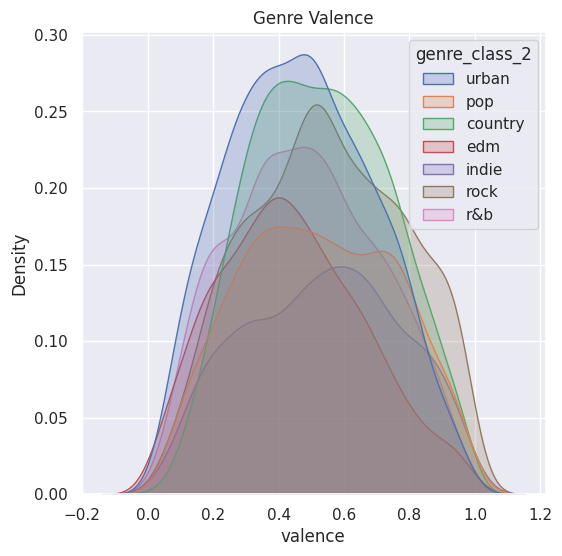

In [5]:
# create a kde plot of the valence and genres
sns.set(rc = {'figure.figsize':(6,6)})
sns.kdeplot(data=sp, x='valence', hue='genre_class_2', fill=True).set_title('Genre Valence')

Each genre clusters differently so a simple global regressor may underpredict very happy country/pop tracks or overpredict low-valence indie tracks. 

### How has the positivity of music changed throughout the years?

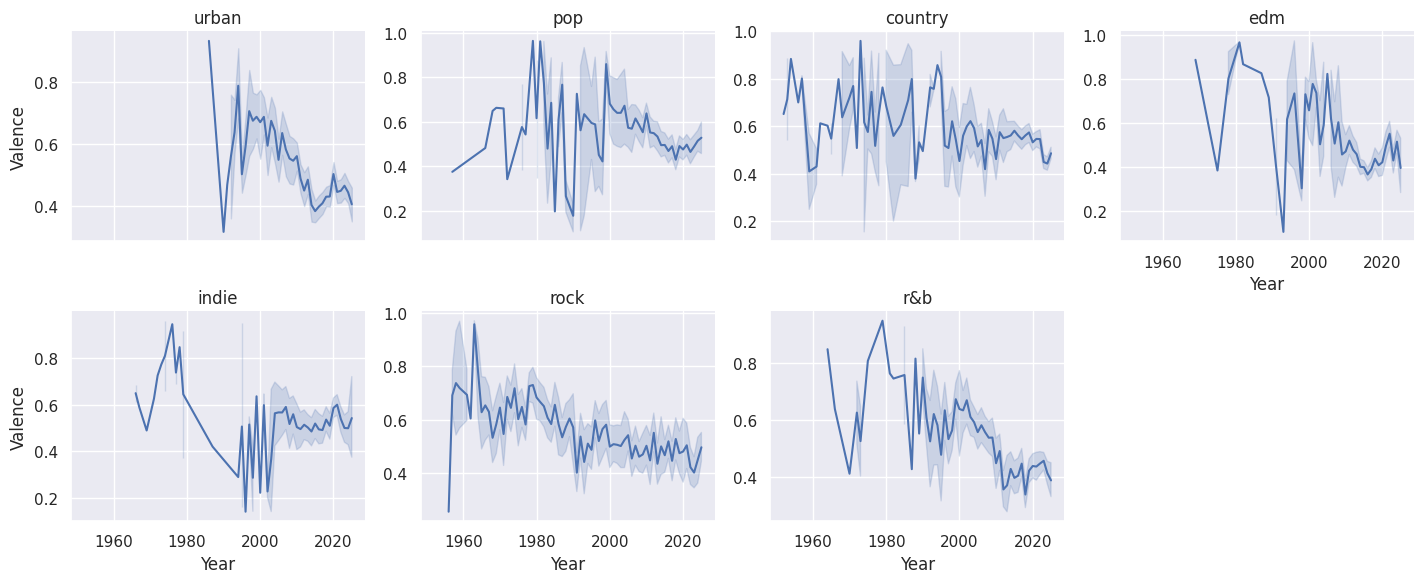

In [6]:
# add the release year to the dataframe
sp['release_year'] = sp['release'].dt.year

# create the line plots, one for each genre
g = sns.relplot(data=sp
                , x='release_year'
                , y='valence'
                , kind='line'
                , col='genre_class_2'  # one plot per genre
                , col_wrap=4           # controls number of plots per row
                , height=3
                , aspect=1.2
                , facet_kws={'sharey': False}  # so each plot can have its own y-scale
)

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Valence")
plt.tight_layout()
plt.show()

In general, it seems that valence has slowly decreased for each genre apart from pop which seems to have a new rise in valence.   

### Do songs released during a particular month have a higher valence?

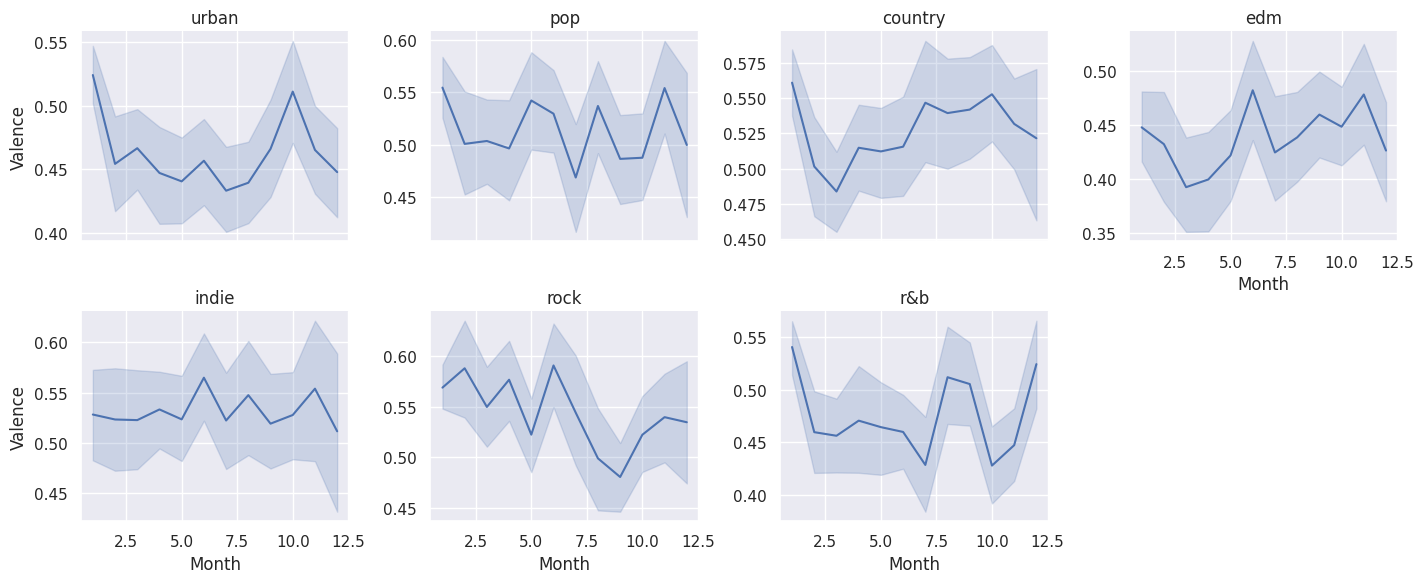

In [7]:
# add the release year to the dataframe
sp['release_month'] = sp['release'].dt.month

# create the line plots, one for each genre
g = sns.relplot(data=sp
                , x='release_month'
                , y='valence'
                , kind='line'
                , col='genre_class_2'  # one plot per genre
                , col_wrap=4           # controls number of plots per row
                , height=3
                , aspect=1.2
                , facet_kws={'sharey': False}  # so each plot can have its own y-scale
)

g.set_titles("{col_name}")
g.set_axis_labels("Month", "Valence")
plt.tight_layout()
plt.show()

For most genres, the sadder songs tend to be released in the latter months around October. We can see this drop in urban, pop, country, edm, indie, and rock. R&B dips at October and takes a sudden rise following. This makes sense as with the colder weather, people seem to lean towards sadder or more acoustic songs.

 ### Do songs that are considered more popular have a higher valence?

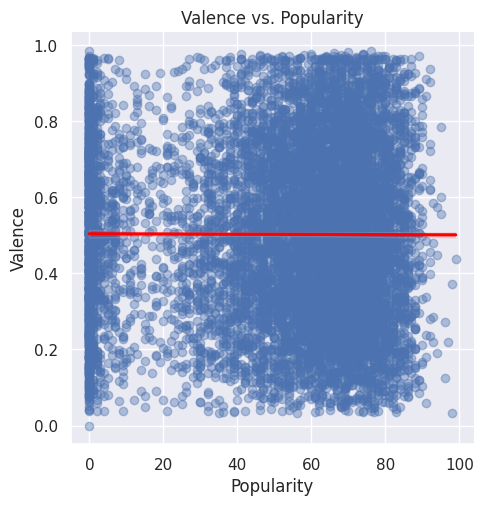

In [8]:
# create the plot and assign labels
sns.lmplot(x='popularity', y='valence', data=sp, scatter_kws={'alpha':0.4}, line_kws={'color': 'red'})
plt.title("Valence vs. Popularity")
plt.xlabel("Popularity")
plt.ylabel("Valence")
plt.show()

This plot output tells us that popularity and valence don't have an aparent linear relationship. 

In [9]:
# get the correlation between the variables
sp[['popularity', 'valence']].corr()

,popularity,valence
popularity,1.000000,-0.003231
valence,-0.003231,1.000000


The correlation betweeen popularity and valence is -0.0032 which is very small. That fits what we determined from our plot. 

Let's try a regplot instead to get more information on the relationship.

Text(0.5, 1.0, 'Valence vs. Popularity (Smoothed)')

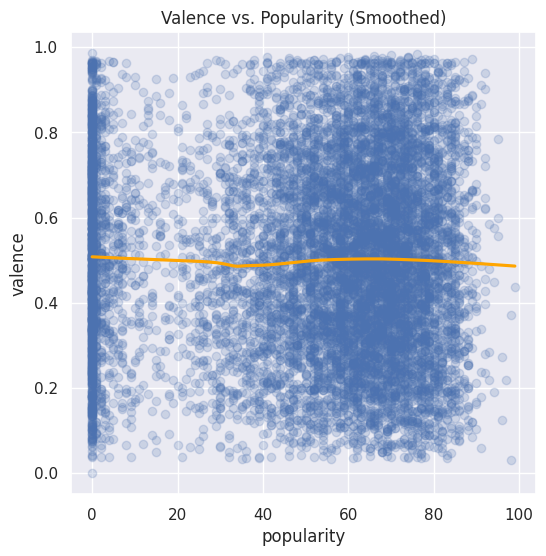

In [10]:
sns.regplot(x='popularity', y='valence', data=sp, lowess=True, scatter_kws={'alpha':0.2}, line_kws={'color':'orange'})
plt.title("Valence vs. Popularity (Smoothed)")

The valence is pretty steady around 0.5 but dips around 30 and then picks back up around 50. 

Let's look at the correlation heatmap to see the overall linear relationship between our variables.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


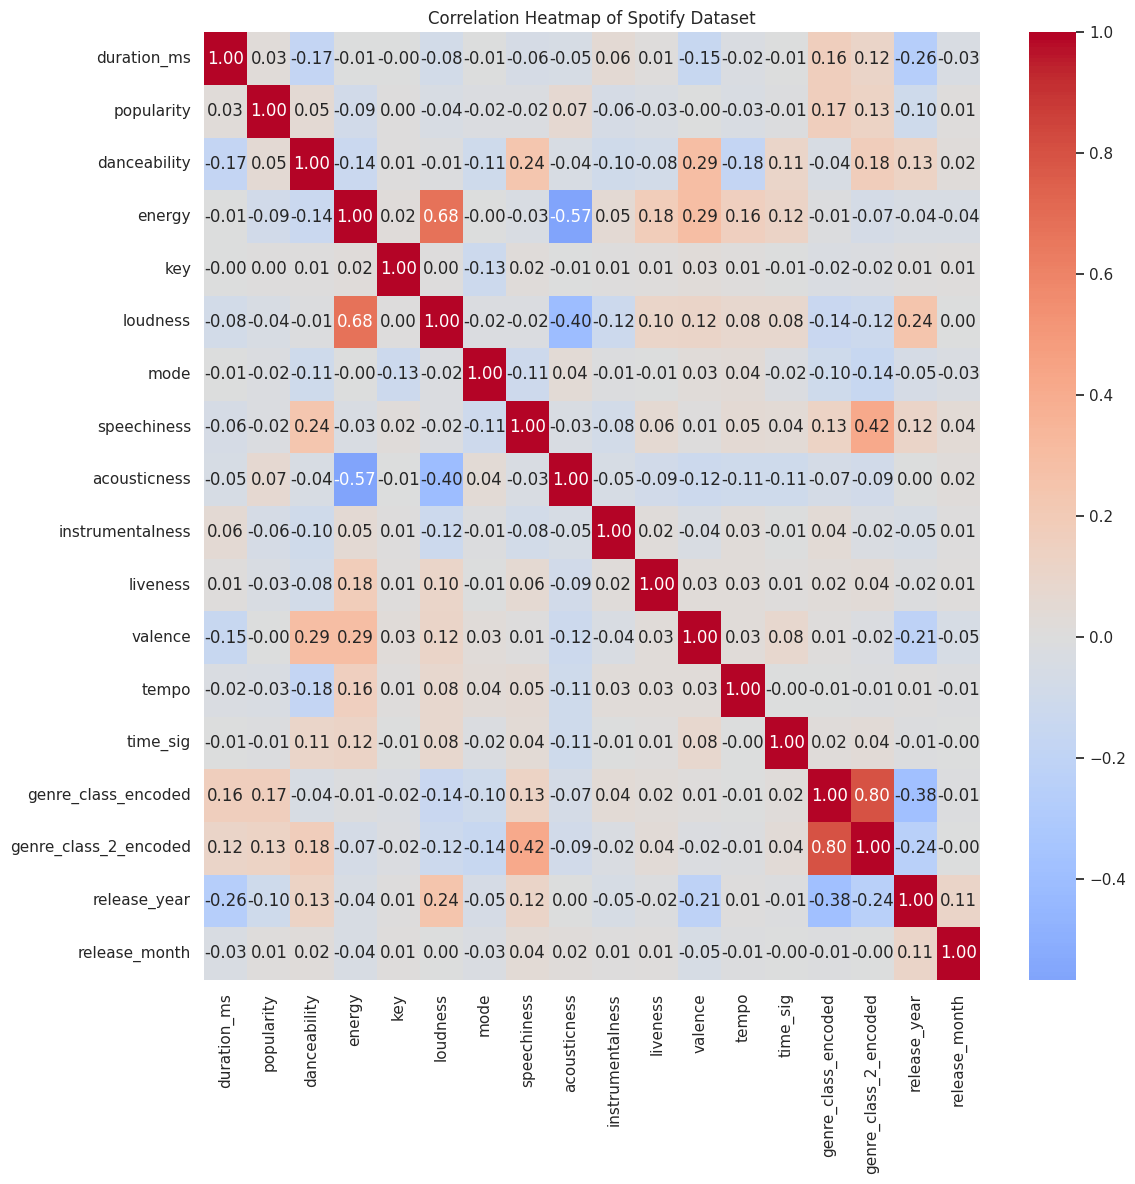

In [11]:
# compute correlation matrix
corr = sp.corr(numeric_only=True)

# set up the matplotlib figure
plt.figure(figsize=(12, 12))

# draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title("Correlation Heatmap of Spotify Dataset")
plt.tight_layout()
plt.show()

Most of the fields are not very strongly correlated. 

The strongest positive correlations are
1. Energy and liveness - with a 0.68 correlation.
2. Sppechiness and genre_class_2_encoded - with a 0.42 correlation. It's interesting that the correlation is stronger after having combined our hiphop and rap genres.
3. Valence and danceability - with a 0.29 correlation.
4. Valence and energy - with a 0.29 correlation.
5. Speechiness and danceability - with a 0.24 correlation.

The strongest negative correlations are
1. Energy and acoustiness - with a -0.57 correlation.
2. Loudness and acoustines - with a -0.40 correlation.
3. Release_year and genre_class_encoded - with a -0.38 correlation.
4. Duration_ms and release_year - with a -0.26 correlation.

### Do we expect that more energy means more positivity?

Valence and energy have a correlation of 0.29. They have a lower positive linear relationship which means that they sometimes change in the same direction (valence and energy both go up or down together). 

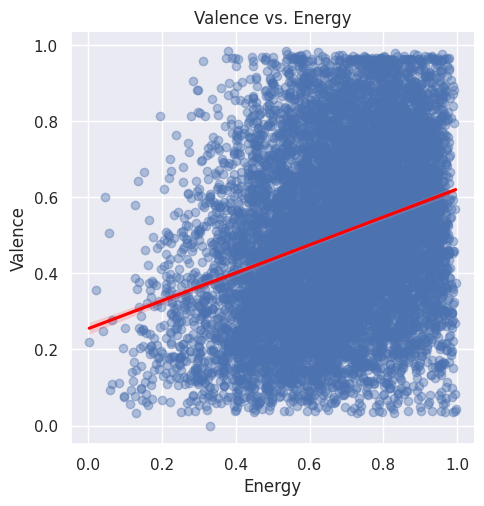

In [12]:
# plot valence vs energy
sns.lmplot(x='energy', y='valence', data=sp, scatter_kws={'alpha':0.4}, line_kws={'color': 'red'})
plt.title("Valence vs. Energy")
plt.xlabel("Energy")
plt.ylabel("Valence")
plt.show()

From the plot, we can see that the data does not have a strong linear relationship. Maybe we can see the relationship more clearly by binning the energy variable.

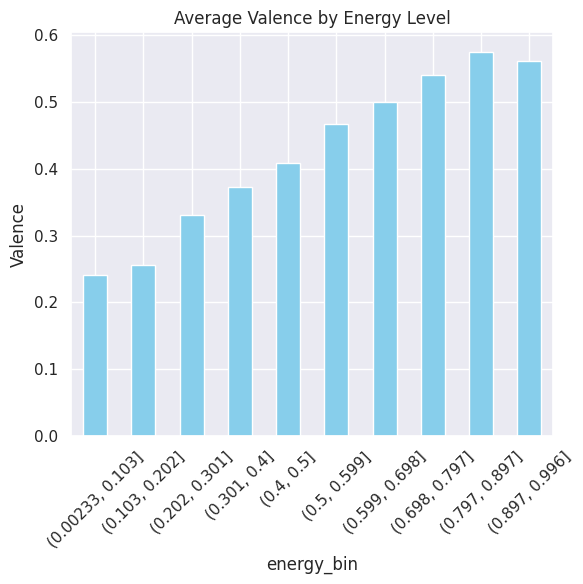

In [13]:
sp['energy_bin'] = pd.cut(sp['energy'], bins=10)
avg_valence = sp.groupby('energy_bin')['valence'].mean()

avg_valence.plot(kind='bar', color='skyblue')
plt.title('Average Valence by Energy Level')
plt.ylabel('Valence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In general, we can see that valence and energy increase together. Let's look for outliers (where valence is high and energy low, or vice versa).

In [14]:
# split the valence and energy into low vs high
high_valence = sp['valence'] > sp['valence'].quantile(0.85)
low_valence = sp['valence'] < sp['valence'].quantile(0.15)
high_energy = sp['energy'] > sp['energy'].quantile(0.85)
low_energy = sp['energy'] < sp['energy'].quantile(0.15)

In [15]:
# retrieve the records that have mismatch energy and valence.
# high valence but low energy (e.g., calm but happy)
happy_chill = sp[high_valence & low_energy]

# high energy but low valence (e.g., intense or angry)
intense_moody = sp[high_energy & low_valence]

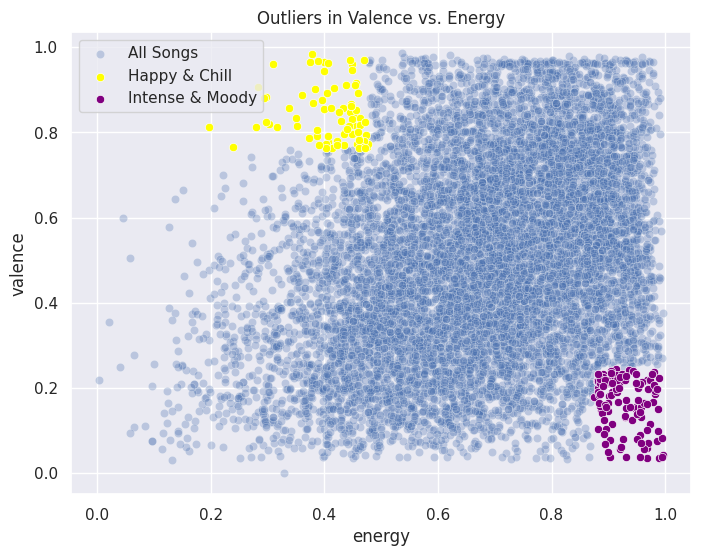

In [16]:
# plot the outliers
plt.figure(figsize=(8,6))
sns.scatterplot(x='energy', y='valence', data=sp, alpha=0.3, label='All Songs')
sns.scatterplot(x='energy', y='valence', data=happy_chill, color='yellow', label='Happy & Chill')
sns.scatterplot(x='energy', y='valence', data=intense_moody, color='purple', label='Intense & Moody')
plt.title('Outliers in Valence vs. Energy')
plt.legend()
plt.show()

In [17]:
# print some of the songs that fall into these outliers
happy_chill[['artist', 'track_name', 'valence', 'energy']].head().sort_values('valence', ascending=False)

,artist,track_name,valence,energy
854,Kanye West,I Love Kanye,0.966,0.374
1078,Ski Mask The Slump God,Unbothered,0.848,0.445
939,Drake,Toosie Slide,0.837,0.454
1031,Kendrick Lamar,Savior - Interlude,0.826,0.430
269,"G-Eazy,Starrah",Order More (feat. Starrah),0.802,0.437


In [18]:
# get the other outliers
intense_moody[['artist', 'track_name', 'valence', 'energy']].head().sort_values('energy', ascending=False)

,artist,track_name,valence,energy
1038,Mötley Crüe,Same Ol' Situation (S.O.S.),0.237,0.980
636,Coheed and Cambria,Welcome Home,0.158,0.951
1076,Papa Roach,Help,0.244,0.914
521,BigXthaPlug,Left Eye,0.146,0.900
630,"Kanye West,Nas,Really Doe",We Major,0.216,0.880


In [19]:
# drop the new bin we created for plotting
sp.drop(['energy_bin'], axis = 1, inplace=True)

### Do sad songs tend to be slower or more acoustic?

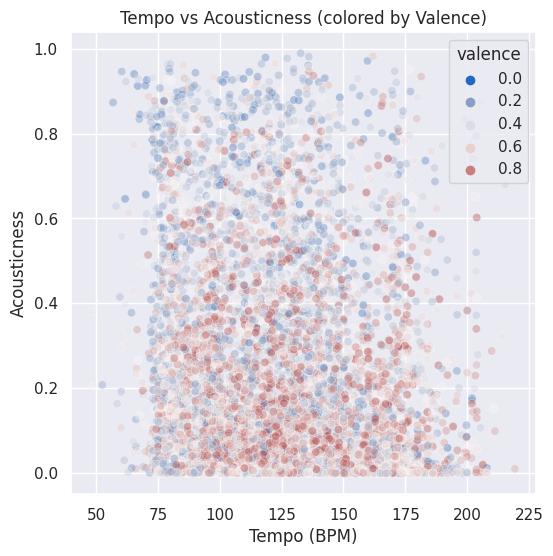

In [20]:
# plot the joint scatterplot to see the relationship
sns.scatterplot(
    x='tempo', 
    y='acousticness', 
    hue='valence', 
    palette='vlag', 
    data=sp, 
    alpha=0.4
)
plt.title('Tempo vs Acousticness (colored by Valence)')
plt.xlabel('Tempo (BPM)')
plt.ylabel('Acousticness')
plt.show()

Based on the plot, it seems that songs that are less acoustic are happier. This aligns with the correlation we calculated earlier of - 0.12.   
Tempo and valence do not seem to have much relationshhip. Again we can go back to the correlation heatmap - tempo and valence only have a correlation of 0.03. Very small linear relationship.

Let's do some t testing to see if the difference is significant. 

In [21]:
# define whether a song is sad
threshold = sp['valence'].quantile(0.25)
sp['mood_group'] = np.where(sp['valence'] < threshold, 'sad', 'not sad')

sp.loc[:, ['valence', 'mood_group']].head(5)

,valence,mood_group
0,0.330,not sad
1,0.141,sad
2,0.449,not sad
3,0.556,not sad
4,0.357,not sad


In [22]:
# group by the mood type and determine the mean and median of tempo and acoustiness for those groups
sp.groupby('mood_group')[['tempo','acousticness']].agg(['mean','median'])

tempo          acousticness        
                  mean   median         mean  median
mood_group                                          
not sad     123.271278  123.036     0.167826  0.0757
sad         122.439667  125.019     0.222576  0.1040

We'll use the null hypothesis that acousticness means are the same for sad vs. other songs.

In [23]:
# run a t test to see if the difference is significant
sad = sp[sp['mood_group']=='sad']
other = sp[sp['mood_group']=='not sad']

# Tempo test
t_stat_tempo, p_val_tempo = ttest_ind(sad['tempo'], other['tempo'], nan_policy='omit')
# Acousticness test
t_stat_acou, p_val_acou = ttest_ind(sad['acousticness'], other['acousticness'], nan_policy='omit')

print(f"Tempo: p={p_val_tempo:.3f}, Acousticness: p={p_val_acou:.3f}")

Tempo: p=0.192, Acousticness: p=0.000


A p-value < 0.05 suggests a statistically significant difference. 
- Tempo has a p value of 0.192 which is greater than 0.05, therefore the difference is not significant. 
- Acousticness has a p value of 0, therefore the difference is signficant. This means that sad song tend to be more acoustic.

We can plot just the relationship between valence and acousticness to get a better view.

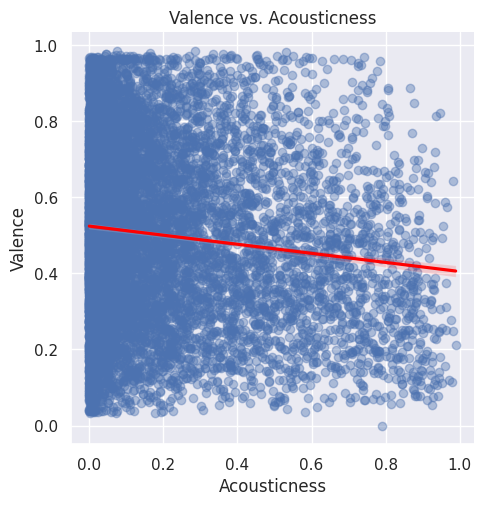

In [24]:
# plot the acousticness vs valence
sns.lmplot(x='acousticness', y='valence', data=sp, scatter_kws={'alpha':0.4}, line_kws={'color': 'red'})
plt.title("Valence vs. Acousticness")
plt.xlabel("Acousticness")
plt.ylabel("Valence")
plt.show()

If we remember from our correlation heatmap, energy and acousticness have a negative linear relationship (correlation = -0.56), but energy and valence have a positive linear relationship (correlation = 0.29). 

What happens if we separate the songs with high and low energy on our plot?

In [25]:
# compare the median and mean energy
print(sp.energy.median())
sp.describe().loc[:, 'energy']

0.693


count    10460.000000
mean         0.675695
min          0.003320
25%          0.551000
50%          0.693000
75%          0.819000
max          0.996000
std          0.179521
Name: energy, dtype: float64

The median is a lower threshold so we can split based on that. 

In [26]:
# split energy by the median
median_energy = sp['energy'].median()
sp['energy_level'] = np.where(sp['energy'] > median_energy, 'high', 'low')

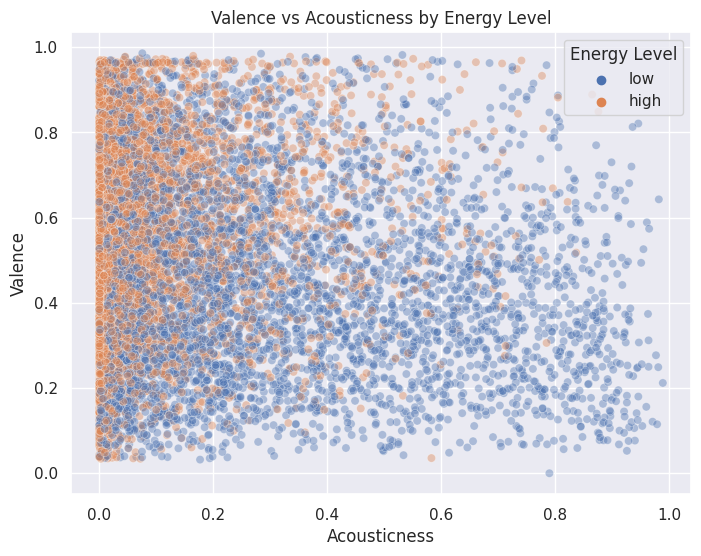

In [27]:
# create a scatterplot with the differences
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=sp,
    x='acousticness',
    y='valence',
    hue='energy_level',
    alpha=0.4
)
plt.title('Valence vs Acousticness by Energy Level')
plt.xlabel('Acousticness')
plt.ylabel('Valence')
plt.legend(title='Energy Level')
plt.show()


From the plot, it seems that songs with low acousticness tend to be more up-beat and happier. That makes sense when we think about songs we consider to be happy. 

### Are songs getting shorter over the years? 

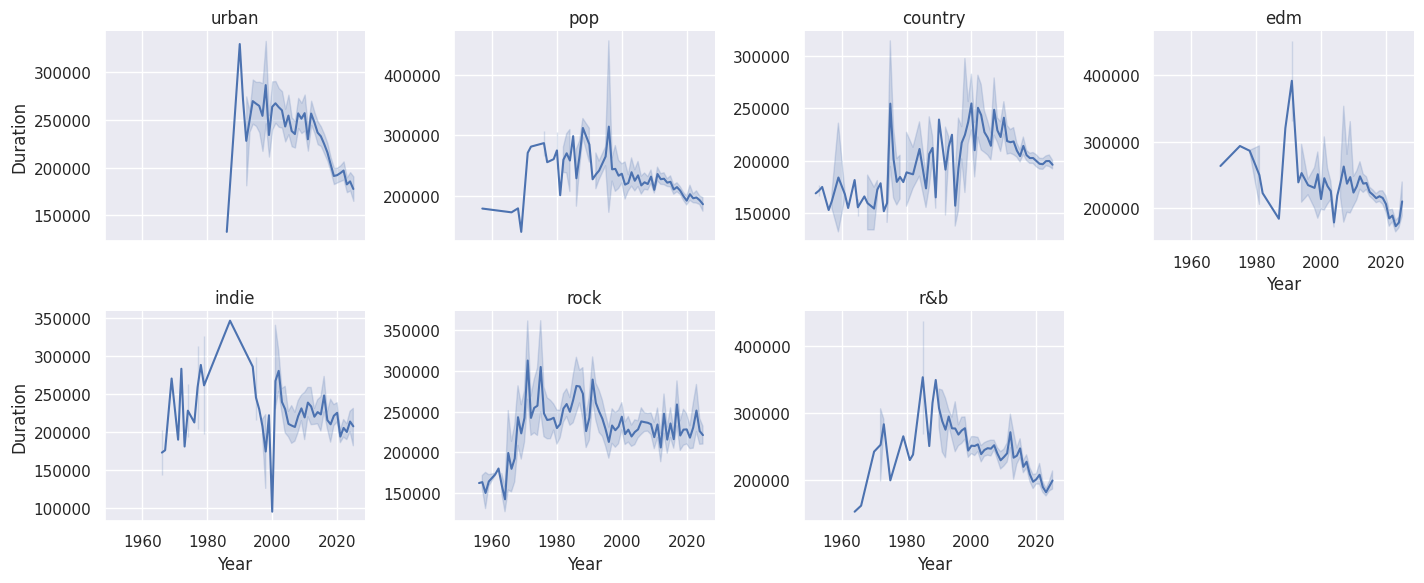

In [28]:
# Create the line plots, one for each genre
g = sns.relplot(data=sp
                , x='release_year'
                , y='duration_ms'
                , kind='line'
                , col='genre_class_2'  # one plot per genre
                , col_wrap=4           # controls number of plots per row
                , height=3
                , aspect=1.2
                , facet_kws={'sharey': False}  # so each plot can have its own y-scale
)

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Duration")
plt.tight_layout()
plt.show()

Songs in every genre seem to be decreasing in length. This decrease is sharper in urban (hiphop/rap), country, edm, and r&b. Edm and Indie seem to have a big drop in song length around the year 2000, but pop and edm seem to have a huge jump. 

Whether we can attribute this to shorter attention span and the rise of reels like TikTok and Instagram is unclear. 

## Data Preprocessing and Mood Classification

To simplify the mood prediction task, we'll convert the `valence` score into a binary label:  
- `1` for "happy" songs (valence > 0.5)  
- `0` for "not happy" songs (valence ≤ 0.5)

We'll also prepare the features and target variable for modeling.

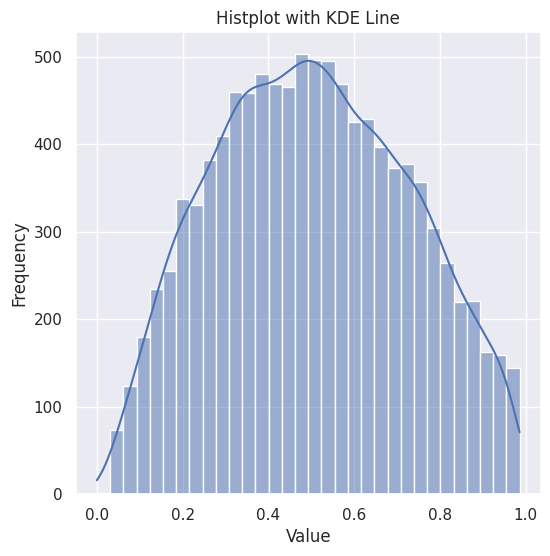

In [29]:
# create the histplot with a KDE line
sns.histplot(sp.valence, kde=True)

# customize the plot
plt.title('Histplot with KDE Line')
plt.xlabel('Value')
plt.ylabel('Frequency')

# display the plot
plt.show()

### Defining our moods

We can see that valence has a fairly normal distribution. We will set the happiness level on scale based on variance  
1 - happy (valence >= 0.5)  
0 - not happy (valence < 0.5)  

In [30]:
# map the moods to our dataset based on valence
sp['mood'] = np.where(sp['valence'] > 0.5, 1, 0)

# print the unique values
sp.mood.value_counts().sort_values()

mood
1    5168
0    5292
Name: count, dtype: int64

Let's print some examples of high vs low valence songs to confirm our mood classification.

In [31]:
# happy songs
sp[sp.valence > 0.5].loc[:, ['track_name', 'artist', 'valence', 'mood']].head(5)

,track_name,artist,valence,mood
3,Slob On My Nob,Tear Da Club Up Thugs,0.556,1
7,Hello Good Morning,"Diddy - Dirty Money,T.I.",0.571,1
9,My Nigga - Remix,"YG,Lil Wayne,Rich Homie Quan,Meek Mill,Nicki M...",0.653,1
11,Papi’s Home,Drake,0.588,1
12,"My Neck, My Back (Lick It)",Khia,0.710,1


In [32]:
# not happy songs
sp[sp.valence < 0.5].loc[:, ['track_name', 'artist', 'valence', 'mood']].head(5)

,track_name,artist,valence,mood
0,Get Me Home,"Foxy Brown,Blackstreet",0.330,0
1,Paris Morton Music,Drake,0.141,0
2,WHAT'S GOOD,"Tyler, The Creator",0.449,0
4,Oh (feat. Ludacris),"Ciara,Ludacris",0.357,0
5,Raindrops (Insane) [with Travis Scott],"Metro Boomin,Travis Scott",0.120,0


## Modeling

Now that the data is prepared, we’ll train and evaluate a few classification models to predict whether a song is 'happy' or 'not happy' based on its audio features.

We’ll use the following models:
- Logistic Regression
- Random Forest
- Support Vector Machine (SVM)
- XGBoost

We'll start by determining which features we want to use in our model.

In [33]:
# create a new dataframe with only the features we are going to use
sp_mood = sp.copy().drop(['track_uri', 'track_name', 'album', 'artist', 'release', 'genres', 'label', 'genre_class', 'genre_class_encoded', 'genre_class_2', 'mood_group', 'energy_level'], axis = 1)

# select our features
features = ['duration_ms', 'popularity', 'danceability', 'energy', 'key','loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'time_sig', 'genre_class_2_encoded']
X = sp_mood[features]
y = sp_mood['mood']

### Mutual Information

We'll calculate the Mutual Information of our features. Features with a high MI score give us more information about the target (mood). Features with a low MI score do not give us a lot of information about the target. 

In [34]:
# calculate mutual information
mi = mutual_info_classif(X, y)

# create a dataframe of mi scores
mi_sp = pd.DataFrame({'Feature': X.columns, 'MI Score': mi})
mi_sp = mi_sp.sort_values(by='MI Score', ascending=False)

print(mi_sp)

                  Feature  MI Score
3                  energy  0.033618
2            danceability  0.026994
10               liveness  0.019829
8            acousticness  0.017153
11                  tempo  0.011993
5                loudness  0.011160
0             duration_ms  0.010626
4                     key  0.003681
13  genre_class_2_encoded  0.003113
12               time_sig  0.002037
1              popularity  0.000000
6                    mode  0.000000
7             speechiness  0.000000
9        instrumentalness  0.000000


The mutual information scores indicate that energy, danceability, and loudness provide the most information about the song's mood. We can drop the variables that do not provide much information such as popularity, key, and mode. 

In [35]:
# we'll create a function to scale, split, and train our models
def scale_split_train (data):
    features = ['duration_ms', 'popularity', 'danceability', 'energy', 'key','loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'time_sig', 'genre_class_2_encoded']
    X = data[features]
    y = data['mood']

    # create a scaler instance
    scaler = StandardScaler()

    # scale X
    X_scaled = scaler.fit_transform(X)

    # split the data into training and test
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'SVM': SVC(),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }
    
    # train and evaluate models
    results = {}

    for model_name, model in models.items():
        # train the model
        model.fit(X_train, y_train)
    
        # predict on test data
        y_pred = model.predict(X_test)
    
        # evaluate the model's accuracy
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
    
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision (macro avg)': report['macro avg']['precision'],
            'Recall (macro avg)': report['macro avg']['recall'],
            'F1 Score (macro avg)': report['macro avg']['f1-score']
        }

    # display results
    results_sp = pd.DataFrame(results).T.sort_values(by='Accuracy', ascending=False)
    return results_sp

scale_split_train(sp_mood)

,Accuracy,Precision (macro avg),Recall (macro avg),F1 Score (macro avg)
Random Forest,0.719885,0.719967,0.719706,0.719725
XGBoost,0.708891,0.708893,0.708759,0.708779
SVM,0.707935,0.708254,0.708121,0.707916
Logistic Regression,0.688337,0.688794,0.688570,0.688288


Our current accuracy for predicting whether the song is happy or not is 71%. Let's try to improve our model. 

### One-Hot Encoding Categorical Audio Features

There are a few audio features that may get confused when read as numerical such as key, mode, time signature, and genre classification.

In [36]:
def grade_range(val):
    if val < 0.3:
        return 'not_happy'
    elif val >= 0.3:
        return 'happy'
    else:
        return None

In [37]:
# list of categorical features to one-hot encode
categorical_features = ['key', 'mode', 'time_sig', 'genre_class_2']

# one-hot encode these features
sp_mood_2 = pd.get_dummies(sp, columns=categorical_features, drop_first=True)

# we'll use the mood dictionary we defined below along with the function
sp_mood_2['mood'] = sp['valence'].apply(grade_range)

# check for nulls
sp_mood_2.mood.isnull().sum()

0

In [38]:
# display the one-hot encoding
sp_mood_2.loc[:5, 'mood':]

,mood,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,...,mode_1,time_sig_3,time_sig_4,time_sig_5,genre_class_2_edm,genre_class_2_indie,genre_class_2_pop,genre_class_2_r&b,genre_class_2_rock,genre_class_2_urban
0,happy,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
1,not_happy,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
2,happy,True,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,True
3,happy,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
4,happy,False,False,False,False,False,False,True,False,False,...,True,False,True,False,False,False,False,False,False,True
5,not_happy,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True


In [39]:
# define the original numerical features
numerical_features = ['duration_ms', 'popularity', 'danceability', 'energy', 
                      'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'tempo']

# drop the mood column from our X and assign the target variable
X = sp_mood_2.drop(columns=['mood'])  
y = sp_mood_2['mood']                 

# scale numerical features
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [40]:
# define cols to drop
drop_cols = ['track_uri','track_name','album','artist','release','genres','label','genre_class','genre_class_encoded','genre_class_2_encoded','release_year'
             ,'release_month','mood_group','energy_level','mood', 'valence']

# features and target
y = sp_mood_2['mood']
X = sp_mood_2.copy().drop(drop_cols, axis = 1)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# predict and evaluate
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8044933078393881

Classification Report:
               precision    recall  f1-score   support

       happy       0.82      0.97      0.89      1633
   not_happy       0.67      0.22      0.33       459

    accuracy                           0.80      2092
   macro avg       0.74      0.59      0.61      2092
weighted avg       0.78      0.80      0.76      2092



That improved our model accuracy! Let's try minimizing the features in our model based on our Mutal Information output with the new features. We'll se a threshhold of 0.01 and higher.

In [41]:
# get the columns we'll be using
cols = ['duration_ms','popularity', 'danceability', 'energy', 'loudness','speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo'
        , 'release_year', 'release_month', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5','key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'mode_1', 'time_sig_3'
        , 'time_sig_4', 'time_sig_5', 'genre_class_2_edm','genre_class_2_indie', 'genre_class_2_pop', 'genre_class_2_r&b','genre_class_2_rock', 'genre_class_2_urban']

X_1 = sp_mood_2.loc[:,cols]
y_1 = sp_mood['mood']

# calculate mutual information
mi = mutual_info_classif(X_1, y_1)

# create a dataframe of MI scores
mi_sp_1 = pd.DataFrame({'Feature': X_1.columns, 'MI Score': mi})
mi_sp_1 = mi_sp_1.sort_values(by='MI Score', ascending=False)

print(mi_sp_1)

                Feature  MI Score
3                energy  0.040834
2          danceability  0.033833
10         release_year  0.021332
8              liveness  0.019099
4              loudness  0.013332
6          acousticness  0.012088
31   genre_class_2_rock  0.011345
0           duration_ms  0.010290
9                 tempo  0.010284
17                key_6  0.010257
15                key_4  0.007939
25           time_sig_4  0.007592
29    genre_class_2_pop  0.007338
24           time_sig_3  0.006875
13                key_2  0.006105
5           speechiness  0.004941
11        release_month  0.004199
7      instrumentalness  0.002932
27    genre_class_2_edm  0.002720
20                key_9  0.002221
21               key_10  0.002097
28  genre_class_2_indie  0.000852
1            popularity  0.000105
30    genre_class_2_r&b  0.000000
26           time_sig_5  0.000000
16                key_5  0.000000
23               mode_1  0.000000
22               key_11  0.000000
19            

We'll set an MI threshhold for 0.01 which means our new features will be: energy, danceability, release_year, liveness, loudness, tempo, and genre_class_2_pop

In [42]:
cols = ['energy', 'danceability', 'release_year', 'liveness', 'loudness', 'tempo', 'genre_class_2_pop']

# features
X_1 = sp_mood_2.loc[:, cols]

# train-test split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# model
model_1 = RandomForestClassifier(random_state=42)
model_1.fit(X_train_1, y_train_1)

# predict and evaluate
y_pred_1 = model_1.predict(X_test_1)

print("Accuracy:", accuracy_score(y_test_1, y_pred_1))
print("\nClassification Report:\n", classification_report(y_test_1, y_pred_1))

Accuracy: 0.7217973231357553

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73      1105
           1       0.70      0.72      0.71       987

    accuracy                           0.72      2092
   macro avg       0.72      0.72      0.72      2092
weighted avg       0.72      0.72      0.72      2092



Our model accuracy decreased. Our previous model provides better results. 

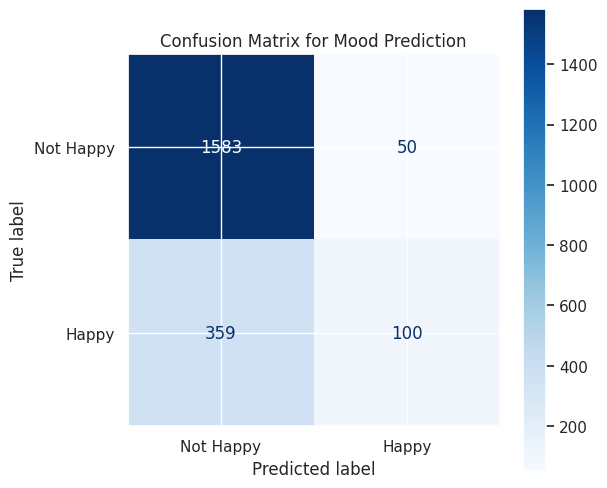

In [43]:
# we can create a confusion matrix to determine which values are getting confused
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Happy", "Happy"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Mood Prediction")
plt.show()

### Interpretation

True Negatives (TN): 835 → Not Happy songs correctly predicted as Not Happy  
False Positives (FP): 270 → Not Happy songs incorrectly predicted as Happy  
False Negatives (FN): 280 → Happy songs incorrectly predicted as Not Happy  
True Positives (TP): 707 → Happy songs correctly predicted as Happy  

We can then calculate the following     
$$Accuracy = \frac{TP + TN}{Total} = \frac{707 + 835}{2092} = 0.737$$   
$$Precision(for happy) = \frac{TP}{TP + FP} = \frac{707}{707 + 270} = 0.723$$   
$$Recall(for happy) = \frac{TP}{TP + FN} = \frac{707}{707 + 280} = 0.716$$  



## Cross Validation

Let's try using Cross Validation to see if we can improve our model. 

In [44]:
# We'll use our X and y from before
model = RandomForestClassifier(random_state=42)

# 5-fold cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated accuracy scores: [0.3207457  0.81214149 0.76912046 0.80066922 0.79971319]
Mean accuracy: 0.7004780114722753


Original test accuracy (74%) was based on a single train-test split, which might’ve been favorable by chance.  
Cross-validation (66%) is a more realistic average of our model’s performance across different subsets.

## Conclusion
Based on accuracy and F1 score, we compared three models: Logistic Regression, Random Forest, XGBoost, and SVM. The results were:

| Model               | Accuracy | F1 Score |
|--------------------|----------|----------|
| Random Forest | 0.72| 0.72 |
| XGBoost | 0.71 | 0.71 |
| SVM | 0.71 | 0.71|
|Logistic Regression| 0.69| 0.69| 

The **Random Forest** model performed the best overall, striking a balance between accuracy and F1 score. It likely benefited from its ability to handle non-linear relationships and feature interactions. We improved on our Random Forest Model by excluding features with low Mutual Information scores and using One-Hot encoding on our categorical audio features such as mode and key. 

---

### Takeaways 

- Audio features from Spotify (like danceability, energy, and loudness) can provide reasonable signals about the mood of a song.

---

### Limitations

- The definition of 'happy' using a threshold on valence alone may not be entirely accurate for listeners. 
- The dataset may be biased toward certain genres or artists, limiting generalizability.

---

### Future Work

- Exploring multi-class or regression-based approaches to preserve more nuance in valence scores.
- Incorporate genre, lyrics, or listener metadata for richer models.
- Use deep learning techniques (e.g., feedforward or CNNs with spectrograms) for raw audio input instead of precomputed features.

---

This project demonstrates how machine learning can be applied to music data to classify emotional tone using structured audio features. It also opens the door to more creative applications at the intersection of data and music.